# Ray Tracing

**Objetivo:** Implementar ray tracing.

**Referências:**
- https://medium.com/@www.seymour/coding-a-3d-ray-tracing-graphics-engine-from-scratch-f914c12bb162
- https://medium.com/@www.seymour/coding-a-3d-ray-tracing-graphics-engine-using-python-and-c-part-2-9b53bcb6fb1b
- https://observablehq.com/@esperanc/raytracing

## Implementation

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Class

An object when hit by a ray could: emit, reflect, absorb, specular reflection (return value)

In [2]:
class Ray:
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction
    
    def at_time_t(self, t):
        return self.origin + t * self.direction

In [3]:
class Material:
    def __init__(self, color, ambient, diffuse, specular, shininess):
        self.color = color
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular
        self.shininess = shininess

In [4]:
epsilon = 10 ** -5

class Sphere:
    def __init__(self, center, radius, material):
        self.center = center
        self.radius = radius
        self.material = material
    
    def normal_at_point(self, point):
        rad = sum(np.square(point - self.center))
        if np.abs(self.radius**2 - rad) < epsilon:
            return 2 * point - self.center
        else:
            raise Exception("Given point is not a point in the Sphere.")
    
    def ray_intersection(self, ray):
        oc = ray.origin - self.center
        a = np.dot(ray.direction, ray.direction)
        b = 2 * np.dot(oc, ray.direction)
        c = np.dot(oc, oc) - self.radius**2

        delta = b**2 - 4*a*c

        if delta >= 0:
            T = None
            t1 = (-b + np.sqrt(delta)) / (2*a)
            t2 = (-b - np.sqrt(delta)) / (2*a)
            if np.isreal(t1) and np.isreal(t2):
                T = min(t1, t2)
            elif np.isreal(t1):
                T = t1
            else:
                T = t2
            dist = T * np.linalg.norm(ray.direction)
            return dist, T
        else:
            return False, False
        

In [5]:
class Light:
    def __init__(self, color, position):
        self.color = color
        self.position = position

### Functions

In [6]:
def length(arr):
    return np.linalg.norm(arr)

In [7]:
def normalize(arr):
    norm = np.linalg.norm(arr)
    return arr / norm

In [8]:
# ref: https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector

def reflection(incident, normal):
    normal = normalize(normal)
    reflected = incident - 2 * (np.dot(incident, normal) * normal)
    return reflected

In [9]:
def first_hit(objects, ray):
    closest_object = None
    min_distance = np.inf
    time = np.inf
    for obj in objects:
        dist, T = obj.ray_intersection(ray)
        if dist != False and dist < min_distance:
            min_distance = dist
            time = T
            closest_object = obj
    if closest_object != None: 
        return [closest_object, min_distance, time]
    else:
        return False

In [10]:
def ray_tracing(ray, objects, lights, level=1):
    black = np.array([0, 0, 0])
    # Check if we hit anything
    hit = first_hit(objects, ray)
    if hit == False:
        return black
    elif hit != False:
        obj, dist, t = hit[0], hit[1], hit[2]

        # Material properties
        color = obj.material.color
        ambient = obj.material.ambient
        diffuse = obj.material.diffuse
        specular = obj.material.specular
        shininess = obj.material.shininess

        # The final color stats with the ambient color
        rgb = color * ambient

        # The hit point
        q = ray.at_time_t(t)
        
        # The hit normal
        n = obj.normal_at_point(q)

        # Vector from surface point to viewer
        qv = -ray.direction
        qv = normalize(qv)

        # Take into account each light
        for light in lights:
            # Vector from surface point to light position
            qp = light.position - q
            light_dist = length(qp)
            qp = normalize(qp)
            
            # Cast shadow ray
            shadow_ray = Ray(origin=q, direction=qp)
            shadow_ray_hit = first_hit(objects, shadow_ray)
            if (shadow_ray_hit != False and shadow_ray_hit[1] >= light_dist):
                # Compute diffuse color
                rgb += color * diffuse * max(0, np.dot(qp, n))
            
            # Non-recursive specular computation if term non-zero
            if (level <= 0 and specular > 0):
                ref = reflection(qp, n)
                if (all(ref != black)):
                    rgb += light.color * specular * np.power(np.dot(ref, qv), shininess)

        # Recursive specular computation if term non-zero
        if (level > 0 and specular > 0):
            # Reflected vector
            ref = reflection(qv, n)
            if (all(ref != black)):
                color = ray_tracing(Ray(origin=q, direction=ref), objects=objects, lights=lights, level=level-1)
                rgb += color * specular
        
        # Clamp to 255
        rgb = rgb % 255
        return rgb

In [11]:
# Convert color representation from 0-255 to 0-1
def convert_color_to_unit(color):
    return (color % 255) / 255

## Making Figure

### Defining objects in the scene

In [12]:
# Colors
red = np.array([255.0, 0.0, 0.0])
green = np.array([0.0, 255.0, 0.0])
blue = np.array([0.0, 0.0, 255.0])
yellow = np.array([255.0, 255.0, 0.0])

# Materials
mat1 = Material(color=red, ambient=0.3, diffuse=0.5, specular=0.8, shininess=1)
mat2 = Material(color=green, ambient=0.3, diffuse=0.5, specular=0.3, shininess=2)

# Spheres
center1 = np.array([-20, -20, -20])
radius1 = 15
sphere1 = Sphere(center=center1, radius=radius1, material=mat1)

center2 = np.array([-10, -10, -10])
radius2 = 5
sphere2 = Sphere(center=center2, radius=radius2, material=mat2)

# Objects
objects = [sphere1, sphere2]

# Ray
origin = np.array([30, 30, 30])
direction = np.array([-1, -1, -1])
ray = Ray(origin=origin, direction=direction)

# Light
light = Light(color=yellow, position=np.array([20, 20, 20]))
lights = [light]

### Plotting each object

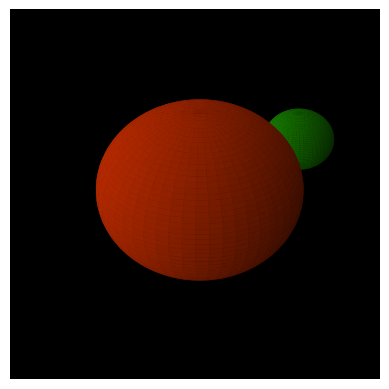

In [13]:
# Definição do plano de projeção
plane_width = 2
plane_height = 2
num_samples = 100

# Criação da figura
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Criação das esferas
spheres_coords = []

for i in range(0, 2):
    sphere = objects[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = sphere.center[0] + sphere.radius * np.outer(np.cos(u), np.sin(v))
    y = sphere.center[1] + sphere.radius * np.outer(np.sin(u), np.sin(v))
    z = sphere.center[2] + sphere.radius * np.outer(np.ones(np.size(u)), np.cos(v))
    spheres_coords.append([x, y, z])

# Aplicação do ray tracing na cena e plot das esferas
for i in range(0, 2):
    sphere = objects[i]
    color = ray_tracing(ray=ray, objects=[sphere], lights=lights)
    object_color = convert_color_to_unit(sphere.material.color + color)
    ax.plot_surface(spheres_coords[i][0], spheres_coords[i][1], spheres_coords[i][2], color=object_color, alpha=1)

# Especificando o vetor câmera
ax.view_init(elev=30, azim=-45)

# Removendo eixos e grade
ax.axis('off')
ax.grid(False)

# Definindo cor de fundo da cena
ax.set_facecolor('black')

# Salvando a cena em um arquivo de imagem
plt.savefig('Cena.png', bbox_inches='tight', pad_inches=0)